In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

import utils

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda:0


In [2]:
# load in data and scale to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_folder = 'data'
trainset = torchvision.datasets.MNIST(root=data_folder, train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root=data_folder, train=False, download=True, transform=transform);

In [3]:
# build the generator
class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1):
        """
        Args:
          nz: Number of elements in the sampled z vector
          ngf: Base size (number of channels) in the generator layers
          nc: Number of channels in the generated images
        """
        super().__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(nz, 4*ngf, 4, bias=False, stride=2, padding=0),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(4*ngf, 2*ngf, 4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2*ngf, ngf, 4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, bias=False, stride=2, padding=3),
            nn.Tanh(),
        )
        
    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise vector z
        
        Args:
            z of shape (batch_size, nz, 1, 1)
            
        Returns:
            output of shape (batch_size, nc, 28, 28)
        """
        out1 = self.layer1(z)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        
        if verbose:
            print(f"Layer1 shape: {out1.shape}")
            print(f"Layer2 shape: {out2.shape}")
            print(f"Layer3 shape: {out3.shape}")
            print(f"Layer4 shape: {out4.shape}")

        return out4

In [4]:
# load pretrained generator from part 2
def load_model(model, filename):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print(f'Model loaded from {filename}')
    model.eval()
    
g_file = 'models/CGANgenerator'
netG = Generator(nz=20, ngf=64, nc=1)
load_model(netG, g_file)

Model loaded from models/CGANgenerator


In [5]:
# adding the conditional information
def one_hot_encode(labels, num_classes=10):
    """given labels of shape (labels) 
    return OHE representation of shape (labels, num_classes, 1, 1)
    """
    return F.one_hot(labels, num_classes).unsqueeze(-1).unsqueeze(-1)

def combine(x, y):
    """For adding class labels to random data"""
    return torch.cat([x, y.float()], dim=1)


In [6]:
def generate_images(labels):
    """Output a generated image with specified labels
    Args:
        labels: list of labels 0-9
    """
    n = len(labels)
    labels = torch.LongTensor(labels)
    ohe = one_hot_encode(labels)
    z = torch.randn(n, 10, 1, 1)
    z_data = combine(z, ohe)
    with torch.no_grad():
        output = netG(z_data)
    return output

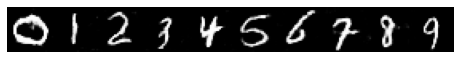

In [7]:
utils.plot_generated_samples(generate_images([0,1,2,3,4,5,6,7,8,9]))

Use lenet as a classification network with the following architecture

* 2d convolutional layer with:
    * one input channel
    * 6 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [8]:
# Create a image classifier inspired by lenet
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # YOUR CODE HERE
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, 5), # 6 x 24 x 24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 6 x 12 x 12
            nn.Conv2d(6, 16, 5), # 16 x 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16 x 4 x 4
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        return self.layers(x)

In [9]:
def validate(classifier):
    """Get accuracy on the testing set"""
    testloader = torch.utils.data.DataLoader(testset, batch_size=25)
    total_images = len(testset)
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            logits = classifier(images)
            preds = logits.argmax(dim=1)
            correct = torch.count_nonzero(labels == preds)
            total_correct += correct.item()
    
    return total_correct / total_images

In [ ]:
# first train using the whole real training data
model = LeNet5().to(device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, num_workers=4, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

for epoch in range(epochs):
    losses = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, loss={np.mean(losses):.3f}, acc={validate(model)}')

In [ ]:
validate(model)

So training with the entire real data we can achieve at least 99 % accuracy.

Next lets try training with a small subset of the real data.

In [79]:
trainset_size = len(trainset)
percentage = 0.03
n_to_take = int(trainset_size * percentage)
print(n_to_take)
indices = np.random.choice(range(0, trainset_size), size=n_to_take, replace=False)
train_subset = torch.utils.data.Subset(trainset, indices)

model = LeNet5().to(device)
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=500, num_workers=4, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

for epoch in range(epochs):
    losses = []
    if epoch == 30:
            optimizer.param_groups[0]['lr'] = 0.0005  # decrease lr when halfway through training
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, loss={np.mean(losses):.3f}, acc={validate(model)}')

1800
Epoch: 1, loss=2.268, acc=0.3748
Epoch: 2, loss=1.843, acc=0.4943
Epoch: 3, loss=1.215, acc=0.6706
Epoch: 4, loss=0.929, acc=0.7055
Epoch: 5, loss=0.751, acc=0.7767
Epoch: 6, loss=0.575, acc=0.8275
Epoch: 7, loss=0.468, acc=0.8679
Epoch: 8, loss=0.376, acc=0.8901
Epoch: 9, loss=0.303, acc=0.9066
Epoch: 10, loss=0.250, acc=0.9119
Epoch: 11, loss=0.224, acc=0.924
Epoch: 12, loss=0.181, acc=0.9294
Epoch: 13, loss=0.156, acc=0.9329
Epoch: 14, loss=0.137, acc=0.9296
Epoch: 15, loss=0.121, acc=0.938
Epoch: 16, loss=0.098, acc=0.9395
Epoch: 17, loss=0.091, acc=0.9415
Epoch: 18, loss=0.077, acc=0.9471
Epoch: 19, loss=0.070, acc=0.9467
Epoch: 20, loss=0.057, acc=0.9456


So just using a randomly selected 10% of the real training data, the model is able to achieve 97% percent accuracy.

Now lets start mixing real training data and the fake images generated by our generator.

In [10]:
class FakeDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        # create labels
        self.n = n
        self.labels = np.random.choice(range(0, 10), size=self.n, replace=True).tolist()
        self.images = generate_images(self.labels)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return (self.images[index], self.labels[index])

In [15]:
fakeset = FakeDataset(60_000)

In [16]:
def generate_trainingset(n_images, n_real):
    """Generate a mixed training set
    Args:
        n_images: how many images in total the set should include
        n_real: how many real images should be used
    """
    n_fake = n_images - n_real
    # take random subset of the real data
    trainset_size = len(trainset)
    indices_real = np.random.choice(range(0, trainset_size), size=n_real, replace=False)
    train_subset = torch.utils.data.Subset(trainset, indices_real)
    
    # generate fake images
    fakeset_size = len(fakeset)
    indices_fake = np.random.choice(range(0, fakeset_size), size=n_fake, replace=False)
    fake_subset = torch.utils.data.Subset(fakeset, indices_fake)
    # and combine
    generated_set = torch.utils.data.ConcatDataset([train_subset, fake_subset])
    return generated_set

lets try training with 100% fake data

In [36]:
def mixed_training(n_images, n_real, epochs=10):
    model = LeNet5().to(device)
    generated_trainset = generate_trainingset(n_images, n_real)
    trainloader = torch.utils.data.DataLoader(generated_trainset, batch_size=1024, num_workers=4, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        if epoch >= (epochs / 2):
            optimizer.param_groups[0]['lr'] = 0.0005  # decrease lr when halfway through training
        losses = []
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = loss_fn(logits, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print(f'Epoch: {epoch+1}, loss={np.mean(losses):.3f}, acc={validate(model)}')
    return model

In [26]:
mixed_training(60_000, 0, epochs=12)

Epoch: 1, loss=0.498, acc=0.9304
Epoch: 2, loss=0.048, acc=0.9577
Epoch: 3, loss=0.024, acc=0.9615
Epoch: 4, loss=0.017, acc=0.9556
Epoch: 5, loss=0.014, acc=0.9641
Epoch: 6, loss=0.014, acc=0.9625
Epoch: 7, loss=0.009, acc=0.9598
Epoch: 8, loss=0.006, acc=0.9578
Epoch: 9, loss=0.006, acc=0.9626
Epoch: 10, loss=0.007, acc=0.9655
Epoch: 11, loss=0.002, acc=0.9642
Epoch: 12, loss=0.001, acc=0.9646
Epoch: 13, loss=0.001, acc=0.9651
Epoch: 14, loss=0.001, acc=0.964
Epoch: 15, loss=0.001, acc=0.9644
Epoch: 16, loss=0.001, acc=0.9636
Epoch: 17, loss=0.001, acc=0.9649
Epoch: 18, loss=0.001, acc=0.9649
Epoch: 19, loss=0.001, acc=0.9637
Epoch: 20, loss=0.001, acc=0.9648


So as we can see, using 60 000 fake images, we achieve an accuracy of around 96% at best.

Lets try next using only 5% of real data

In [31]:
# 5 % of real data
mixed_training(60_000, 3000, epochs=20)

Epoch: 1, loss=0.509, acc=0.935
Epoch: 2, loss=0.057, acc=0.9528
Epoch: 3, loss=0.035, acc=0.9618
Epoch: 4, loss=0.023, acc=0.9678
Epoch: 5, loss=0.018, acc=0.9674
Epoch: 6, loss=0.015, acc=0.9646
Epoch: 7, loss=0.012, acc=0.9713
Epoch: 8, loss=0.013, acc=0.9724
Epoch: 9, loss=0.010, acc=0.9696
Epoch: 10, loss=0.007, acc=0.9715
Epoch: 11, loss=0.004, acc=0.9758
Epoch: 12, loss=0.002, acc=0.9762
Epoch: 13, loss=0.002, acc=0.9754
Epoch: 14, loss=0.002, acc=0.976
Epoch: 15, loss=0.002, acc=0.9762
Epoch: 16, loss=0.002, acc=0.9759
Epoch: 17, loss=0.001, acc=0.9756
Epoch: 18, loss=0.001, acc=0.976
Epoch: 19, loss=0.001, acc=0.9759
Epoch: 20, loss=0.001, acc=0.9756


In [32]:
# 10 % real data
mixed_training(60_000, 6_000, epochs=20)

Epoch: 1, loss=0.521, acc=0.9351
Epoch: 2, loss=0.079, acc=0.9537
Epoch: 3, loss=0.049, acc=0.9637
Epoch: 4, loss=0.035, acc=0.9635
Epoch: 5, loss=0.030, acc=0.9687
Epoch: 6, loss=0.026, acc=0.9621
Epoch: 7, loss=0.021, acc=0.9702
Epoch: 8, loss=0.018, acc=0.971
Epoch: 9, loss=0.015, acc=0.9751
Epoch: 10, loss=0.014, acc=0.9737
Epoch: 11, loss=0.008, acc=0.9781
Epoch: 12, loss=0.006, acc=0.9784
Epoch: 13, loss=0.005, acc=0.9789
Epoch: 14, loss=0.005, acc=0.9786
Epoch: 15, loss=0.005, acc=0.9783
Epoch: 16, loss=0.004, acc=0.9775
Epoch: 17, loss=0.004, acc=0.9777
Epoch: 18, loss=0.004, acc=0.9788
Epoch: 19, loss=0.004, acc=0.9779
Epoch: 20, loss=0.004, acc=0.9776


In [33]:
# 20 % real data
mixed_training(60_000, 12_000, epochs=20)

Epoch: 1, loss=0.629, acc=0.9299
Epoch: 2, loss=0.081, acc=0.9628
Epoch: 3, loss=0.048, acc=0.9684
Epoch: 4, loss=0.036, acc=0.97
Epoch: 5, loss=0.032, acc=0.9752
Epoch: 6, loss=0.022, acc=0.9759
Epoch: 7, loss=0.019, acc=0.9769
Epoch: 8, loss=0.016, acc=0.9774
Epoch: 9, loss=0.014, acc=0.9782
Epoch: 10, loss=0.015, acc=0.9769
Epoch: 11, loss=0.007, acc=0.9825
Epoch: 12, loss=0.005, acc=0.9828
Epoch: 13, loss=0.004, acc=0.9822
Epoch: 14, loss=0.004, acc=0.9832
Epoch: 15, loss=0.003, acc=0.9831
Epoch: 16, loss=0.003, acc=0.9827
Epoch: 17, loss=0.003, acc=0.9825
Epoch: 18, loss=0.003, acc=0.9828
Epoch: 19, loss=0.002, acc=0.9826
Epoch: 20, loss=0.002, acc=0.9826


In [34]:
# 50% real data
mixed_training(60_000, 30_000, epochs=20)

Epoch: 1, loss=0.627, acc=0.9499
Epoch: 2, loss=0.092, acc=0.975
Epoch: 3, loss=0.056, acc=0.9769
Epoch: 4, loss=0.047, acc=0.9793
Epoch: 5, loss=0.036, acc=0.984
Epoch: 6, loss=0.033, acc=0.9825
Epoch: 7, loss=0.027, acc=0.9855
Epoch: 8, loss=0.023, acc=0.988
Epoch: 9, loss=0.018, acc=0.985
Epoch: 10, loss=0.018, acc=0.9847
Epoch: 11, loss=0.010, acc=0.9892
Epoch: 12, loss=0.007, acc=0.9893
Epoch: 13, loss=0.007, acc=0.9887
Epoch: 14, loss=0.006, acc=0.989
Epoch: 15, loss=0.006, acc=0.989
Epoch: 16, loss=0.005, acc=0.9888
Epoch: 17, loss=0.005, acc=0.989
Epoch: 18, loss=0.005, acc=0.9884
Epoch: 19, loss=0.004, acc=0.9888
Epoch: 20, loss=0.004, acc=0.988


In [38]:
# 100 % real data
m = mixed_training(60_000, 60_000, epochs=20)

Epoch: 1, loss=0.595, acc=0.9589
Epoch: 2, loss=0.105, acc=0.9744
Epoch: 3, loss=0.071, acc=0.9819
Epoch: 4, loss=0.054, acc=0.9856
Epoch: 5, loss=0.046, acc=0.9884
Epoch: 6, loss=0.036, acc=0.9889
Epoch: 7, loss=0.031, acc=0.9856
Epoch: 8, loss=0.027, acc=0.9873
Epoch: 9, loss=0.025, acc=0.987
Epoch: 10, loss=0.022, acc=0.9873
Epoch: 11, loss=0.012, acc=0.9908
Epoch: 12, loss=0.010, acc=0.9915
Epoch: 13, loss=0.009, acc=0.9912
Epoch: 14, loss=0.009, acc=0.9916
Epoch: 15, loss=0.008, acc=0.9917
Epoch: 16, loss=0.008, acc=0.9919
Epoch: 17, loss=0.008, acc=0.9914
Epoch: 18, loss=0.007, acc=0.9916
Epoch: 19, loss=0.007, acc=0.9918
Epoch: 20, loss=0.007, acc=0.9916


In [62]:
# find out what real examples the model misclassifies
testloader = torch.utils.data.DataLoader(testset, batch_size=1)
misclassified = []
for image, label in testloader:
    image = image.to(device)
    pred = m(image).argmax(dim=1).item()
    label = label.item()
    if pred != label:
        misclassified.append((image, label))

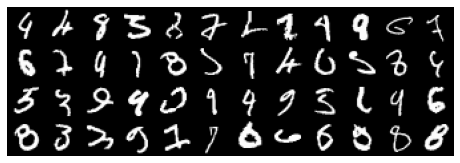

In [64]:
for_plotting = torch.concat([misclassified[n][0] for n in range(48)])
utils.plot_generated_samples(for_plotting, savename='misclassified-real.jpg')

In [57]:
# find out what fake examples the model misclassifies
testloader = torch.utils.data.DataLoader(fakeset, batch_size=1)
misclassified = []
for image, label in testloader:
    image = image.to(device)
    pred = m(image).argmax(dim=1).item()
    label = label.item()
    if pred != label:
        misclassified.append((image, label))

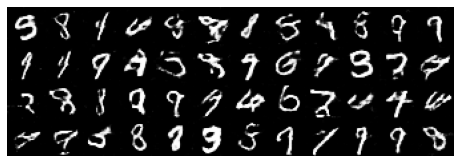

In [61]:
for_plotting = torch.concat([misclassified[n][0] for n in range(48)])
utils.plot_generated_samples(for_plotting, savename='misclassified-fake.jpg')

In [77]:
# less data in total
# 3% of total, 1800 real samples + 3200 fake

model = LeNet5().to(device)
generated_trainset = generate_trainingset(10_000, 1800)
trainloader = torch.utils.data.DataLoader(generated_trainset, batch_size=1024, num_workers=4, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

for epoch in range(epochs):
    if epoch == 15:
        optimizer.param_groups[0]['lr'] = 0.0005  # decrease lr when halfway through training
    losses = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, loss={np.mean(losses):.3f}, acc={validate(model)}')


Epoch: 1, loss=1.706, acc=0.7073
Epoch: 2, loss=0.521, acc=0.8846
Epoch: 3, loss=0.239, acc=0.9207
Epoch: 4, loss=0.138, acc=0.9371
Epoch: 5, loss=0.096, acc=0.9476
Epoch: 6, loss=0.067, acc=0.955
Epoch: 7, loss=0.057, acc=0.955
Epoch: 8, loss=0.049, acc=0.9604
Epoch: 9, loss=0.040, acc=0.9626
Epoch: 10, loss=0.032, acc=0.965
Epoch: 11, loss=0.028, acc=0.9642
Epoch: 12, loss=0.024, acc=0.9639
Epoch: 13, loss=0.030, acc=0.965
Epoch: 14, loss=0.026, acc=0.9646
Epoch: 15, loss=0.020, acc=0.9667
Epoch: 16, loss=0.014, acc=0.9704
Epoch: 17, loss=0.011, acc=0.9704
Epoch: 18, loss=0.010, acc=0.9708
Epoch: 19, loss=0.009, acc=0.9711
Epoch: 20, loss=0.009, acc=0.9706


In [81]:
0.9456 - 0.9706

-0.025000000000000022